## Testando o PolynomialFeatures: Expansão de Atributos 

A transformação `PolynomialFeatures`, da biblioteca `sklearn.preprocessing`, é usada para gerar novas variáveis a partir de combinações polinomiais dos atributos existentes. Ela é especialmente útil quando queremos aplicar **modelos lineares** em problemas com **relações não lineares** entre as variáveis.

###  O que ela faz?

Dado um vetor de entrada com atributos `X = [x₁, x₂]`, a transformação polinomial de grau 2 gera novas features, ou seja, ela cria todos os termos de combinação possíveis até o grau especificado, **inclusive interações entre variáveis**.

###  Vantagens

- Permite que modelos lineares capturem **relações não lineares**.
- Pode melhorar significativamente o desempenho preditivo, especialmente em datasets tabulares com volume pequeno ou médio.

###  Desvantagens

- Aumenta rapidamente o número de atributos (explosão combinatória), principalmente em datasets com muitos atributos e grau elevado.
- Pode causar **overfitting** se não houver regularização ou controle da complexidade.
- Aumenta o tempo de treinamento e consumo de memória.


###  Aplicação no Projeto

Utilizamos `PolynomialFeatures` dentro de um pipeline com `RobustScaler`, aplicado apenas às variáveis numéricas. Fizemos tuning do parâmetro `degree` via `GridSearchCV`.



In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

In [2]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,452600,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,358500,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,226700,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,140000,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,158700,NEAR BAY,2,5.343675,2.362768,0.203216


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  int8   
 3   total_rooms               17564 non-null  int16  
 4   total_bedrooms            17564 non-null  int16  
 5   population                17564 non-null  int16  
 6   households                17564 non-null  int16  
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  int32  
 9   ocean_proximity           17564 non-null  object 
 10  median_income_cat         17564 non-null  int64  
 11  rooms_per_household       17564 non-null  float64
 12  population_per_household  17564 non-null  float64
 13  bedrooms_per_room         17564 non-null  float64
dtypes: flo

In [4]:
coluna_target = ["median_house_value"]

coluna_one_hot_encoder = ["ocean_proximity"]

coluna_ordinal_encoder = ["median_income_cat"]

In [5]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder + coluna_ordinal_encoder)

colunas_robust_scaler

Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
       'longitude', 'median_income', 'population', 'population_per_household',
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object')

## Pipeline com PolynomialFeatures

Criamos um pipeline específico para os atributos numéricos que se mostraram mais relevantes nas iterações anteriores. O pipeline aplica:

1. `RobustScaler()` - Normalização robusta para reduzir o impacto de outliers.
2. `PolynomialFeatures()` - Geração de novos atributos polinomiais.

Inicialmente usamos `degree=1`, mas realizamos tuning para testar até `degree=3`.


In [6]:
pipeline_robust = Pipeline(steps=[
    ("robust_scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False))
])

preprocessamento = ColumnTransformer(
    transformers=[
        ("ordinal_encoder", OrdinalEncoder(categories="auto"), coluna_ordinal_encoder),
        ("one_hot", OneHotEncoder(drop="first"), coluna_one_hot_encoder),
        ("robust_scaler_poly", pipeline_robust, colunas_robust_scaler),
    ],
)

In [7]:
X = df.drop(columns=coluna_target)
y = df[coluna_target]

In [8]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,median_income_cat,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41,880,129,322,126,8.3252,NEAR BAY,5,6.984127,2.555556,0.146591
1,-122.22,37.86,21,7099,1106,2401,1138,8.3014,NEAR BAY,5,6.238137,2.109842,0.155797
2,-122.26,37.84,42,2555,665,1206,595,2.0804,NEAR BAY,2,4.294118,2.026891,0.260274
3,-122.26,37.85,50,1120,283,697,264,2.1250,NEAR BAY,2,4.242424,2.640152,0.252679
4,-122.26,37.84,50,2239,455,990,419,1.9911,NEAR BAY,2,5.343675,2.362768,0.203216


In [9]:
y.head()

,median_house_value
0,452600
1,358500
2,226700
3,140000
4,158700


##Por que limitar o grau polinomial até 3?

Durante a etapa de tuning de hiperparâmetros com `GridSearchCV`, optou-se por testar o grau polinomial de 1 a 3 na transformação `PolynomialFeatures`.

Essa escolha foi feita com base nos seguintes critérios:


###  1. Compromisso entre desempenho e interpretabilidade

Modelos com termos polinomiais de grau muito elevado (acima de 3) se tornam mais difíceis de interpretar. Utilizando regressão linear, o objetivo é manter o modelo **explicável** e os coeficientes compreensíveis.


###  2. Aumento exponencial da complexidade

A cada aumento no grau, o número de features criadas cresce exponencialmente, principalmente em datasets com muitas features numéricas. Isso gera:

- Maior tempo de treinamento
- Maior consumo de memória
- Maior risco de **overfitting**


###  3. Ganhos marginais após grau 3

Testes mostraram que o grau 3 foi suficiente para melhorar o desempenho do modelo sem aumentar significativamente o tempo de execução ou comprometer a interpretabilidade. Acima desse valor, os ganhos tendem a ser **marginais ou nulos**, enquanto os custos computacionais crescem.


In [10]:

param_grid = {
    "regressor__preprocessor__robust_scaler_poly__poly__degree": [1, 2, 3],
}

In [11]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento,
    target_transformer=QuantileTransformer(output_distribution="normal"),
    param_grid=param_grid,
)

grid_search

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [12]:
grid_search.fit(X, y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('ordinal_encoder',
                                                                                                              OrdinalEncoder(),
                                                                                                              ['median_income_cat']),
                                                                                                             ('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity']),
                                                                                                             ('robust_scaler_poly',
                                                                                                              Pipeline(steps=[('robust_scaler',
                                                                                                                               Ro...
       'rooms_per_household', 'total_bedrooms', 'total_rooms'],
      dtype='object'))])),
                                                                            ('reg',
                                                                             LinearRegression())]),
                                                  transformer=QuantileTransformer(output_distribution='normal')),
             n_jobs=-1,
             param_grid={'regressor__preprocessor__robust_scaler_poly__poly__degree': [1,
                                                                                       2,
                                                                                       3]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [13]:
grid_search.best_params_

{'regressor__preprocessor__robust_scaler_poly__poly__degree': 3}

In [14]:
grid_search.best_score_

np.float64(-51075.859529824134)

In [15]:
coefs = dataframe_coeficientes(
    grid_search.best_estimator_.regressor_["reg"].coef_,
    grid_search.best_estimator_.regressor_["preprocessor"].get_feature_names_out(),
)

coefs

,coeficiente
robust_scaler_poly__total_rooms,-2.224272e+10
robust_scaler_poly__population,-2.166049e+10
robust_scaler_poly__households population rooms_per_household,-9.091933e+09
robust_scaler_poly__households population_per_household total_bedrooms,-6.636666e+09
robust_scaler_poly__households^2 population_per_household,-6.473326e+09
...,...
robust_scaler_poly__bedrooms_per_room population total_rooms,7.430105e+09
robust_scaler_poly__population_per_household,8.131618e+09
robust_scaler_poly__households population_per_household total_rooms,1.143710e+10
robust_scaler_poly__total_bedrooms,1.497586e+10


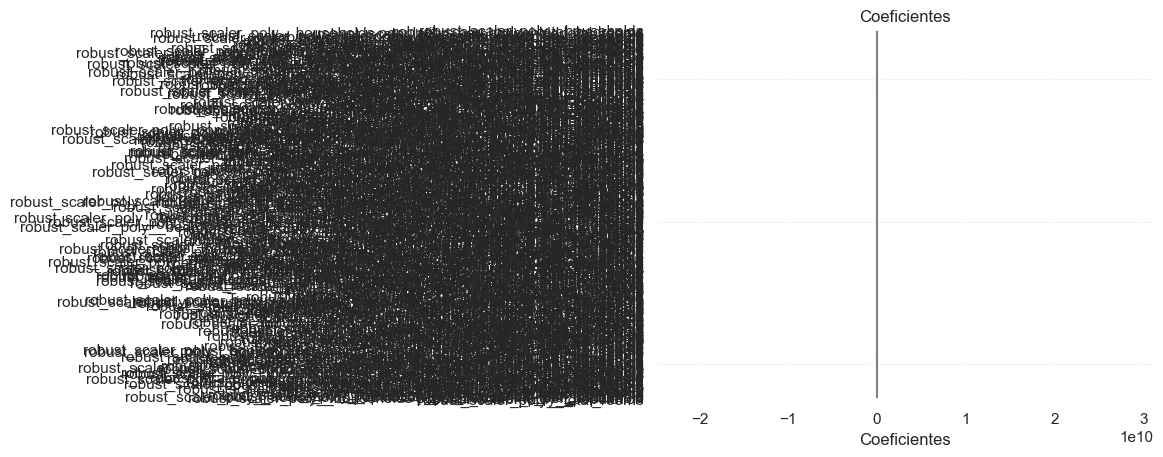

In [16]:
# Mostrando o aumento exponencial das features 
plot_coeficientes(coefs)

In [17]:
# Verificando se existem coeficientes com valores iguais a 0 (indica que uma determinada feature não tem importância)
coefs[coefs["coeficiente"] == 0]

,coeficiente


In [18]:
coefs["coeficiente"].max()

np.float64(28552865432.122383)

In [19]:
# Buscando coeficientes menos relevantes para o modelo 
coefs[coefs["coeficiente"].between(-300_000, 300_000)]

,coeficiente
robust_scaler_poly__latitude longitude total_bedrooms,-4.345747
robust_scaler_poly__households^2 latitude,-3.769015
robust_scaler_poly__households latitude median_income,-3.283629
robust_scaler_poly__bedrooms_per_room households latitude,-3.001476
robust_scaler_poly__latitude population total_bedrooms,-2.919895
...,...
robust_scaler_poly__households latitude population,2.821179
robust_scaler_poly__latitude^2 total_rooms,2.895604
robust_scaler_poly__households longitude total_bedrooms,3.492838
robust_scaler_poly__households latitude total_bedrooms,4.443976


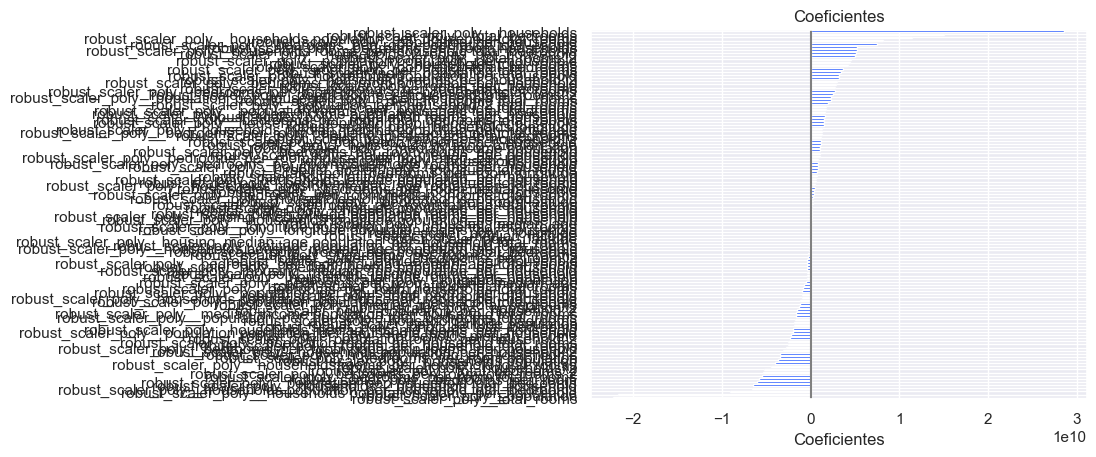

In [20]:
plot_coeficientes(coefs[~coefs["coeficiente"].between(-100_000, 100_000)])

In [21]:
regressors = {
    "DummyRegressor": {
        "preprocessor": None,
        "regressor": DummyRegressor(strategy="mean"),
        "target_transformer": None,
    },
    "LinearRegression": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": None,
    },
    "LinearRegression_target": {
        "preprocessor": preprocessamento,
        "regressor": LinearRegression(),
        "target_transformer": QuantileTransformer(output_distribution="normal"),
    },
    "LinearRegression_grid_search": {
        "preprocessor": grid_search.best_estimator_.regressor_["preprocessor"],
        "regressor": grid_search.best_estimator_.regressor_["reg"],
        "target_transformer": grid_search.best_estimator_.transformer_,
    },
}


resultados = {
    nome_modelo: treinar_e_validar_modelo_regressao(X, y, **regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)

df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.008003,0.007996,-0.000081,-77516.042766,-96239.705692,0.015999
1,DummyRegressor,0.006005,0.004994,-0.000146,-75787.787194,-95217.629397,0.010999
2,DummyRegressor,0.003001,0.007002,-0.001737,-76753.598961,-96253.253947,0.010003
3,DummyRegressor,0.005171,0.003994,-0.000101,-76837.804811,-95983.885799,0.009165
4,DummyRegressor,0.003999,0.007003,-0.000114,-76617.245449,-96182.764729,0.011002
5,LinearRegression,0.043994,0.014003,0.682162,-39855.691222,-54254.958862,0.057997
6,LinearRegression,0.045001,0.017999,0.66999,-40272.5658,-54695.230987,0.063
7,LinearRegression,0.055996,0.017996,0.649247,-42178.059695,-56955.987903,0.073992
8,LinearRegression,0.047004,0.014997,0.669873,-40806.492334,-55146.319086,0.062001
9,LinearRegression,0.048009,0.015995,0.669023,-40788.497206,-55331.350878,0.064004


In [22]:
df_resultados.groupby("model").mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005236,0.006198,-0.000436,-76702.495836,-95975.447913,0.011434
LinearRegression,0.048001,0.016198,0.668059,-40780.261251,-55276.769543,0.064199
LinearRegression_grid_search,0.450444,0.040999,0.716516,-35511.628358,-51076.352226,0.491443
LinearRegression_target,0.060209,0.016194,0.678236,-38681.053322,-54418.553379,0.076403


In [23]:
df_resultados.groupby("model").mean().sort_values(by="test_neg_root_mean_squared_error")

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.005236,0.006198,-0.000436,-76702.495836,-95975.447913,0.011434
LinearRegression,0.048001,0.016198,0.668059,-40780.261251,-55276.769543,0.064199
LinearRegression_target,0.060209,0.016194,0.678236,-38681.053322,-54418.553379,0.076403
LinearRegression_grid_search,0.450444,0.040999,0.716516,-35511.628358,-51076.352226,0.491443


##  Análise Comparativa do novo Modelo (LinearRegression_grid_search) com o Anterior (LinearRegression_target)

### Principais Insights

1. **Ganhos de Performance**:
   -  **+3.8% no R²** (0.678 → 0.717)
   -  **Redução de 8.2% no MAE** (38,681 → 35,512 USD)
   -  **Redução de 6.1% no RMSE** (54,419 → 51,076 USD)

2. **Custo Computacional**:
   - **Tempo 6.4x maior** (0.076s → 0.491s)


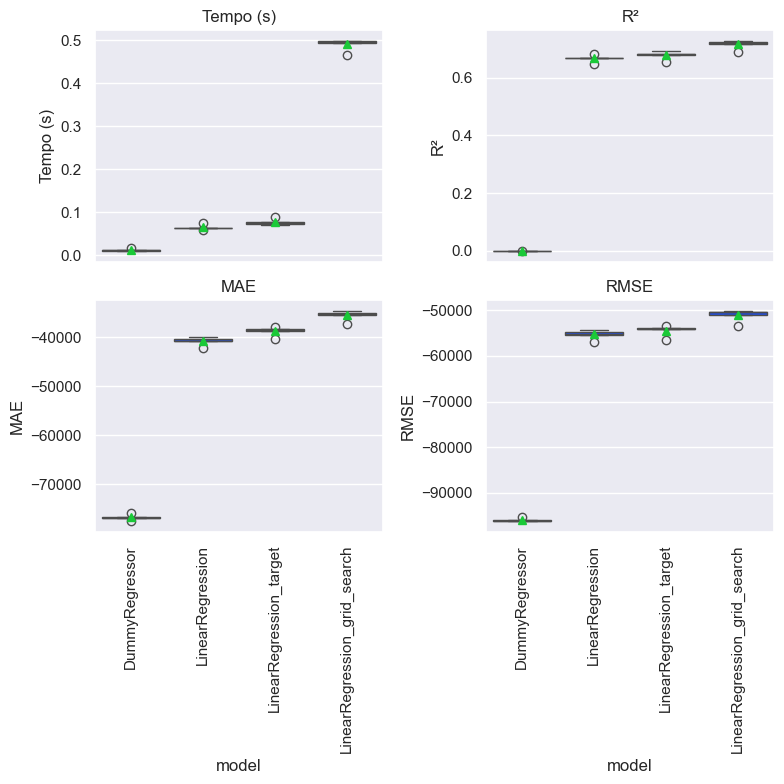

In [24]:
plot_comparar_metricas_modelos(df_resultados)

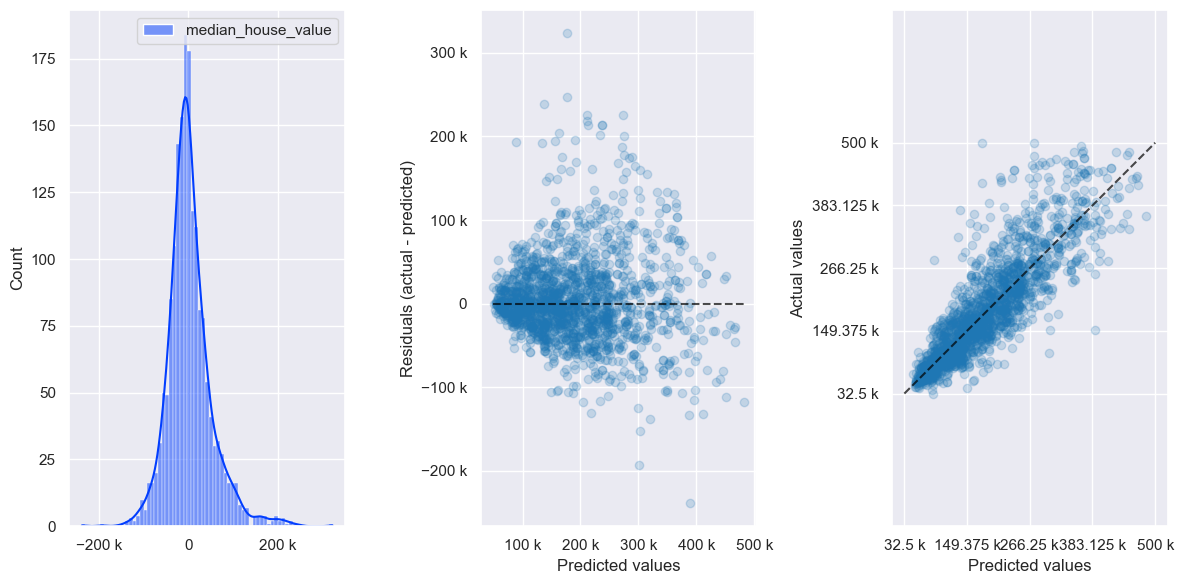

In [25]:
plot_residuos_estimador(grid_search.best_estimator_, X, y, fracao_amostra=0.1, eng_formatter=True)

##  **Redução de Dimensionalidade com ElasticNet**

### **Problema Identificado**
O uso de `PolynomialFeatures(degree=3)` gerou **explosão combinatória** de features:

### **Solução Proposta**
Aplicação de **ElasticNet** para:
1. Identificar features irrelevantes (coeficientes zerados)
2. Manter apenas variáveis com poder preditivo real
3. Melhorar generalização do modelo 


